In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [87]:
# libraries to build algorithm
import sys
import numpy as np
from numpy import linalg as la
# libraries to import data
from sklearn.datasets import make_blobs
# libraries for plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# libraries for in-built algorithm
from sklearn import cluster
# libraries for timing
from time import time

In [58]:
# custom classes and functions
sys.path.append('..')
from utils.plotting import plot_clustering

## Load data

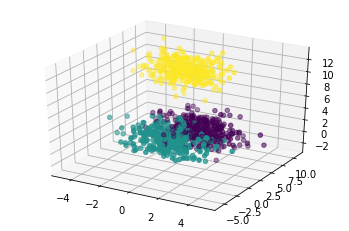

In [67]:
X, y = make_blobs(n_samples=1000, n_features=3, cluster_std=1.3, random_state=0)
plot_clustering(X, y)

In [68]:
X.shape, y.shape

((1000, 3), (1000,))

## Algorithm

In [85]:
class KMeans():
    def __init__(self, K, method = 'mean', max_iter = 100, min_percent_loss_decrease = None):
        self.K = K
        self.method = method
        self.max_iter = max_iter
        self.min_percent_loss_decrease = min_percent_loss_decrease
        self.cost = None
        self.centroids = None
        self.clusters = None
        
    def init_centroids(self, X):
        '''returns k random points from X as centroids'''
        return X[np.random.randint(X.shape[0], size = self.K)]
        
    def euclidean_distance(self, A, B):
        '''A: (m, n)
        B: (k, n)
        return: (m, k) euclidean distance matrix'''
        # uses: (a - b)**2 = a**2 + b**2 - 2*a*b: (a.dot(a) + b.dot(b) - 2a.dot(b))
        # credit: https://www.dabblingbadger.com/blog/2020/2/27/implementing-euclidean-distance-matrix-calculations-from-scratch-in-python
        A_dot_B = np.matmul(A,B.T)
        A_dot_A = np.sum(A*A, axis=1).reshape(-1,1) * np.ones(A_dot_B.shape)
        B_dot_B = np.sum(B*B, axis=1) * np.ones(A_dot_B.shape)
        squared_distance = A_dot_A + B_dot_B - 2*A_dot_B
        # avoiding sqrt of negative number
        zero_mask = np.less(squared_distance, 0.0)
        squared_distance[zero_mask] = 0.0
        return np.sqrt(squared_distance)
    
    def closest_centroid_index(self, dist_matrix):
        return np.argmin(dist_matrix, axis=1)
    
    def loss_did_not_decrease(self, loss_before, loss, threshold):
        if loss_before is not None and loss is not None and threshold is not None:
            return (loss_before - loss) / loss_before < threshold
        return False
    
    def converged(self, clusters_before, clusters):
        if clusters_before is not None and clusters is not None:
            return list(clusters_before) == list(clusters)
        return False
    
    def group(self, array, grouper):
        a = np.concatenate((array, grouper.reshape(-1,1)), axis=1)
        a = a[np.argsort(a[:,-1])]
        return np.split(a[:,:-1], np.unique(a[:, -1], return_index=True)[1][1:])
    
    def within_cluster_distortion(self, cluster, centroid):
        '''cluster: (q,n) array, where q is the number of samples in the cluster
        centroid: (1,n) array
        returns the sum of squared distances between the cluster point and its centroid'''
        return np.sum(np.power(cluster - centroid, 2))
    
    def compute_cost(self, grouped_X):
        return np.sum([self.within_cluster_distortion(cluster, centroid) for cluster, centroid in zip(grouped_X, self.centroids)]) / self.X.shape[0]
    
    def reassign_centroids(self, grouped_X):
        return np.array([np.mean(x, axis=0) for x in grouped_X]).reshape(self.K, self.X.shape[1])
             
    def fit(self, X):
        self.X = X
        i = 0
        loss_before = None
        clusters_before = None
        self.centroids = self.init_centroids(X)
        while(i <= self.max_iter and not self.loss_did_not_decrease(loss_before, self.cost, self.min_percent_loss_decrease) and not self.converged(clusters_before, self.clusters)):
            clusters_before = self.clusters
            loss_before = self.cost
            dist_matrix = self.euclidean_distance(self.X, self.centroids)
            self.clusters = self.closest_centroid_index(dist_matrix)
            grouped_X = self.group(self.X, self.clusters)
            self.cost = self.compute_cost(grouped_X)
            self.centroids = self.reassign_centroids(grouped_X)
    
    def predict(self, X_test):
        dist_matrix = self.euclidean_distance(X_test, self.centroids)
        return self.closest_centroid_index(dist_matrix)

## Apply algorithm

In [82]:
kmeans = KMeans(K = 3, min_percent_loss_decrease = 0.05)
kmeans.fit(X)
y_pred = kmeans.predict(X)

In [75]:
kmeans.cost

4.847012419194023

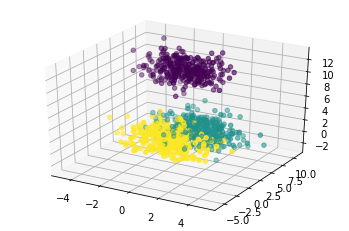

In [77]:
plot_clustering(X, y_pred)

In [90]:
# timeit
duration = []
for i in range(100):
    s = time()
    kmeans = KMeans(K = 3, min_percent_loss_decrease = 0.05)
    kmeans.fit(X)
    duration.append(time() - s)
print('taken {} seconds'.format(round(np.mean(duration),4)))

taken 0.0023 seconds


## Compare with in-built algorithm

In [91]:
kmeans2 = cluster.KMeans(n_clusters = 3)
kmeans2.fit(X)
y_pred2 = kmeans2.predict(X)

In [92]:
kmeans2.inertia_ / X.shape[0]

4.847012419194022

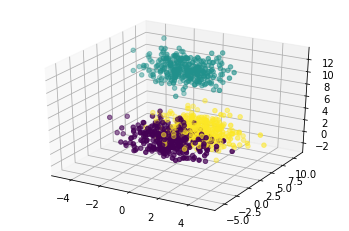

In [93]:
plot_clustering(X, y_pred2)

In [95]:
# timeit
duration = []
for i in range(100):
    s = time()
    kmeans2 = cluster.KMeans(n_clusters = 3)
    kmeans2.fit(X)
    duration.append(time() - s)
print('taken {} seconds'.format(round(np.mean(duration),4)))

taken 0.0384 seconds
